<h1>Titanic Survival Prediction</h1>
<h3>Description</h3>
<p>Titanic Dataset on Kaggle comes in two parts, train and test dataset. There are eleven predictor features including 'PassengerId'. The target feature is 'Survived', which can take two values 0 and 1. Each row is a person who boarded the Titanic. Given the predictor variables we have to find if the passenger in the test dataset survived. Our plan would be to fit a <b>Classification algorithm</b> on the train dataset and predict the target variable in test dataset.</p>


In [1040]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler,LabelEncoder
from scipy.stats import chi2_contingency, boxcox
import scipy.stats as stats
import sklearn.preprocessing as preprocessing


In [1041]:
train = pd.read_csv('Dataset/train.csv')
test = pd.read_csv('Dataset/test.csv')

In [1042]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1043]:
train.shape

(891, 12)

In [1044]:
test.shape

(418, 11)

In [1045]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<h3>Check For missing values</h3>

In [1046]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1047]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

<h4> Dealing with train and test dataset missing values</h4>
<p> In train dataset, there are 177 missing values in Age columns, 687 missing values in Cabin column and 2 missing values in Embarked column</p>
<p> In test dataset there are 86 missing values in Age column, 327 missing values in Cabin column and 1 missing value in Fare Column

<h3>Train dataset</h3>

<h3> Embarked Column </h3>
<p>We will work on Embarked column which has two missing values</p>
<p>Let's check the record who has missing values in Embarked column</p>

In [1048]:
train.loc[train.Embarked.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


<p> Both of them have the same Ticket number, that proves that they have embarked from the same city</p>
<p> Mrs Stone boarded the Titanic in <i>Southampton</i> on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28. You can read about her 
    <a href='https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html'>here</a>

In [1049]:
train.loc[train.Embarked.isna(),'Embarked'] = 'S'

In [1050]:
train.loc[train.Cabin == 'B28']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


<h3>Cabin Column</h3>
<p> We will work on Cabin column which has 687 missing values out of 891 values<p>
<p> Since there are a large number of missing values and no possible way to impute the values through feature engineering. Let's check if the <i>Cabin</i> column is <b>dependent column or independent column</b> with the <i>Survived</i> column. We will use <b>Chi-Squared Test</b> to check the statistical significance.</p>
<p> There are two components to the Cabin column. It contain the alphabet which denotes the cabin section and the number denotes the position of the room</p>
<p> We will make a new dataset which contain only those records which have non-null cabin values. Then we will extract the letters from the cabin column and make a new column Cabin Name</p>

In [1051]:
train_Cabin = train.loc[train.Cabin.notna()].copy()

In [1052]:
train_Cabin['cabinName'] = train_Cabin.Cabin.apply(lambda x: str(x)[0])

In [1053]:
train_Cabin.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabinName
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,E
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,G
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,C


In [1054]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(train_Cabin['Survived'],train_Cabin['cabinName']))

Let's set our alpha to 0.05, to check the statistical significance

In [1055]:
alpha = 0.05
if(p<alpha):
    print('p = ',p)
    print('Dependent (reject H0)')
else:
    print('p = ',p)
    print('Independent (fail to reject H0)')

p =  0.1721713412821439
Independent (fail to reject H0)


<p> Moreover we can proved that Cabin column and Pclass column are correlated. Since, the Cabin's in the titanic were given according to the Pclass. </p>

In [1056]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(train_Cabin['Pclass'],train_Cabin['cabinName']))

Setting alpha to 0.05

In [1057]:
alpha = 0.05
if(p<alpha):
    print('p = ',p)
    print('Dependent (reject H0)')
else:
    print('p = ',p)
    print('Independent (fail to reject H0)')

p =  5.720886022010114e-29
Dependent (reject H0)


<p> One possible way to impute the missing values in Cabin column would be by assignment according to the Pclass, but that would lead to high correlation between Pclass and 
    Cabin column. Hence it is safe to say that cabin column has no statistical significance.</p>

<p> We will be dropping the Cabin column</p>

In [1058]:
train.drop(columns='Cabin', inplace = True)
test.drop(columns='Cabin', inplace = True)

<h3>Age Column</h3>
<p> Now we will work on Age column which has 177 missing values out of 891 values in the train dataset</p>
<p> One possible way to impute the age column according to impute the mean of age for each age groups and profession and Pclass</p>
<p> To segregate the data according to age groups and profession we will the need the title given to the passengers.</p>
<p> This information is available in the Name column where each passenger has a title after their surname</p>
<p> The steps would to make a new column Title and impute the missing values based on Title column and Pclass</p>

<h4> Creating Title column </h4>

In [1059]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [1060]:
train['Titles'] = train.Name.apply(lambda x: x.split(', ')[1].split('. ')[0])

In [1061]:
train.Titles.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Ms                1
Jonkheer          1
Capt              1
Lady              1
Mme               1
Sir               1
the Countess      1
Don               1
Name: Titles, dtype: int64

In [1062]:
test['Titles'] = test.Name.apply(lambda x: x.split(', ')[1].split('. ')[0])

In [1063]:
test.Titles.value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Ms          1
Dr          1
Name: Titles, dtype: int64

<p> We can see that there is a range of titles, our next step would be to bin these tiles into <b>Mr,Mrs,Miss,Master,Royalty and Officer</b></p>


In [1064]:
new_titles = {
    'Mr':'Mr',
    'Miss':'Miss',
    'Mrs':'Mrs',
    'Master':'Master',
    'Dr':'Officer',
    'Dona':'Royalty',
    'Rev':'Officer',
    'Mlle':'Miss',
    'Major':'Officer',
    'Col':'Officer',
    'Sir':'Royalty',
    'Don':'Royalty',
    'Capt':'Officer',
    'the Countess':'Royalty',
    'Jonkheer':'Officer',
    'Mme':'Mrs',
    'Lady':'Royalty',
    'Ms':'Miss'
}

In [1065]:
train['Titles'] = train.Titles.map(new_titles)
test['Titles'] = test.Titles.map(new_titles)

In [1066]:
train.Titles.value_counts()

Mr         517
Miss       185
Mrs        126
Master      40
Officer     19
Royalty      4
Name: Titles, dtype: int64

In [1067]:
test.Titles.value_counts()

Mr         240
Miss        79
Mrs         72
Master      21
Officer      5
Royalty      1
Name: Titles, dtype: int64

<p> Let's use a groupby function to impute missing values in the Age column </p>

In [1068]:
train['Age'] = train.groupby(['Titles','Pclass'])['Age'].transform(lambda grp: grp.fillna(np.mean(grp)))

In [1069]:
train['Age'].isna().sum()

0

In [1070]:
test['Age'] = test.groupby(['Titles','Pclass'])['Age'].transform(lambda grp: grp.fillna(np.mean(grp)))

In [1071]:
test['Age'].isna().sum()

0

<h4> Test Dataset </h4>

In [1072]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Titles         0
dtype: int64

<p> The only missing value in test dataset is in Fare column. Let's check the entry</p>

In [1073]:
test.loc[test.Fare.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Titles
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,Mr


<p> We can impute the Fare value according to the mean of Pclass </p> 

In [1074]:
test['Fare'] = test.groupby(['Pclass'])['Fare'].transform(lambda grp: grp.fillna(np.mean(grp)))

In [1075]:
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Titles         0
dtype: int64

In [1076]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Titles         0
dtype: int64

<p> All the missing values have been dealt with and also some of the columns which had a lot of missing values and did not show any statistical significance have been removed </p>

<h3> Dealing with Ticket column </h3>
<p> Ticket column has ticket numbers and the only possible information that we can get from it is the people who has the same ticket number may have had high chance of survival together. It can be shown that the first two digits of Ticket number are related to Pclass. Before moving ahead we need to check the correlation of the column we are going to create with other columns(Pclass).</p>

In [1077]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Titles
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


In [1078]:
similarTicket = train.Ticket.value_counts()

<p> If more than one person has the same ticket we will assign 1 to ticketMate column of the passenger or else 0</p>

In [1079]:
train['ticketMate'] = train.Ticket.apply(lambda x: 1 if similarTicket[x] > 1 else 0)

<p> Now let's check the statistical significance of the new column with Survived column and Pclass column</p>

<h4> Dependence on Survived column</h4>

In [1080]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(train['Survived'],train['ticketMate']))
alpha = 0.05
if(p<alpha):
    print('p = ',p)
    print('Dependent (reject H0)')
else:
    print('p = ',p)
    print('Independent (fail to reject H0)')

p =  4.903020473214121e-11
Dependent (reject H0)


<h4> Dependence on Pclass column </h4>

In [1081]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(train['Pclass'],train['ticketMate']))
alpha = 0.05
if(p<alpha):
    print('p = ',p)
    print('Dependent (reject H0)')
else:
    print('p = ',p)
    print('Independent (fail to reject H0)')

p =  1.6673153896807204e-09
Dependent (reject H0)


<p> It can be seen that although Ticket mate column is statistically significant, it is highly correlated to the Pclass colomn. Hence we will not use it </p>

In [1082]:
train.drop(columns=['Ticket','ticketMate'], inplace = True)

In [1083]:
test.drop(columns=['Ticket'], inplace = True)

<h1> Data Visualization </h1>

<p> We will do the data visualization of Categorical and Numerical columns separately</p>
<p> So lets make the list of the name of numerical columns and categorical columns</p>

In [1084]:
num_cols = train.describe().columns

In [1085]:
cat_cols = train.columns.drop(num_cols)

In [1086]:
num_cols

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [1087]:
cat_cols

Index(['Name', 'Sex', 'Embarked', 'Titles'], dtype='object')

In [1088]:
num_cols = num_cols.drop(['PassengerId','Survived'])

<h2> Histograms of Numerical Columns </h2>

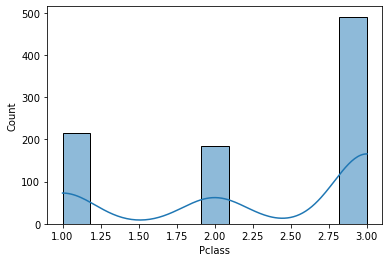

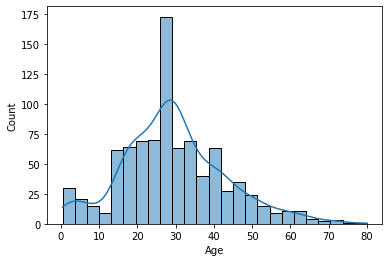

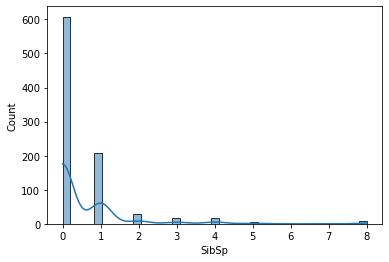

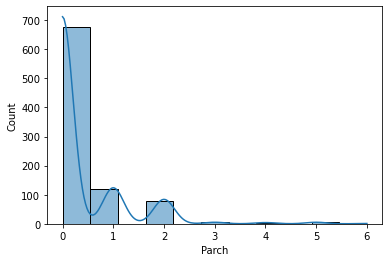

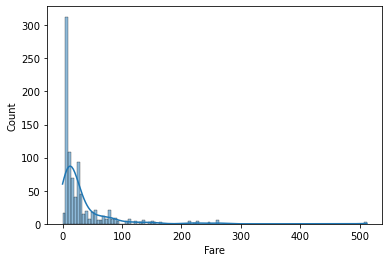

In [1089]:
for col in num_cols:
    sns.histplot(data = train, x = col, kde = True)
    plt.show()

<h2> Filtering numerical columns </h2>
<p> We can see that only <b>Age</b> and <b>Fare</b> fit the definition of numerical columns. We cant prove that other ordinal variables have a linear relationship. Hence we will conver columns other than Age and Fare into categorical columns</p>


In [1090]:
for col in num_cols:
    if ((col!= 'Age') & (col != 'Fare')):
        train[col] = train[col].astype(object)

In [1091]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    object 
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    object 
 7   Parch        891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  Titles       891 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 76.7+ KB


<p> Should do the same for test dataset </p>

In [1092]:
for col in num_cols:
    if ((col!= 'Age') & (col != 'Fare')):
        train[col] = train[col].astype(object)

In [1093]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         418 non-null    float64
 8   Embarked     418 non-null    object 
 9   Titles       418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


<h3> Update the list of Categorical and Numerical columns to fit the defintion </h3>

In [1094]:
num_cols = train.describe().columns
cat_cols = train.columns.drop(num_cols)
num_cols = num_cols.drop(['PassengerId','Survived'])

In [1095]:
num_cols

Index(['Age', 'Fare'], dtype='object')

In [1096]:
cat_cols

Index(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Titles'], dtype='object')

In [1097]:
cat_cols = cat_cols.drop('Name')

<h2> Countplot of Catogorical columns </h2>

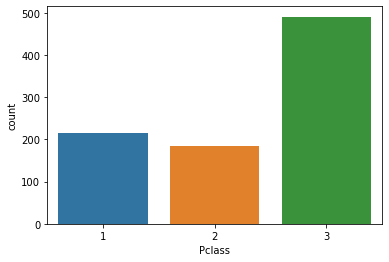

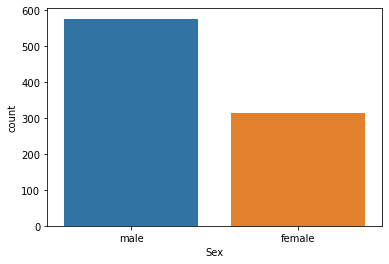

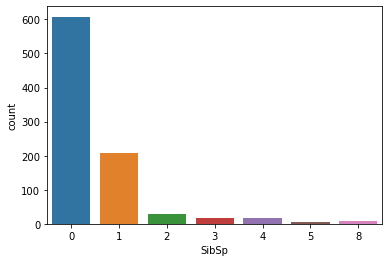

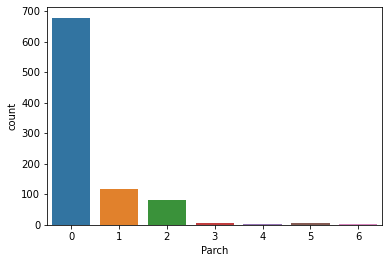

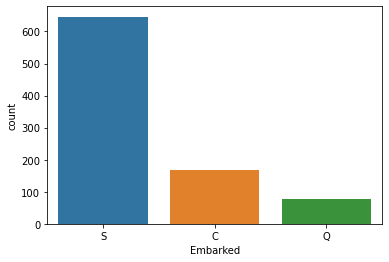

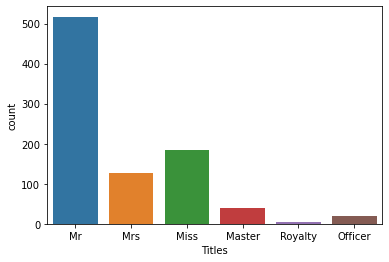

In [1098]:
for col in cat_cols:
    sns.countplot(data=train, x = col)
    plt.show()

<AxesSubplot:xlabel='Survived', ylabel='count'>

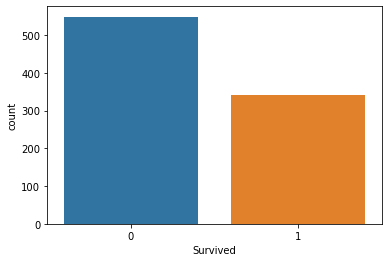

In [1099]:
sns.countplot(data = train, x='Survived')

<h2> Boxplot of Numerical columns with Survived column </h2>

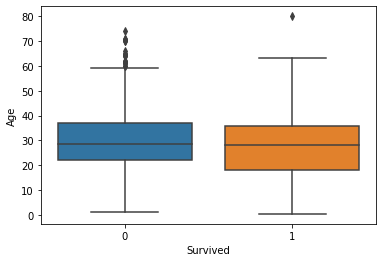

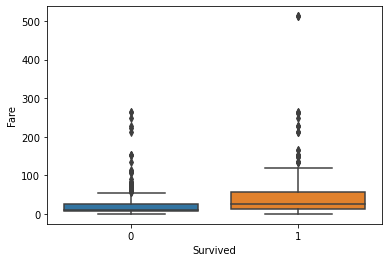

In [1100]:
for col in num_cols:
    sns.boxplot(data = train, x='Survived', y = col)
    plt.show()

<h2> Outliers in numerical columns </h2>
<p> It can be seen that Age and Fare column are <b>not normally distributed</b> and from the histograms and kde plot it can be seen that they are <b>right skewed</b>. We will handle this in our next step which is Data Preprocessing</p>

<p> Before that let's visualize categorical columns by using Survived as hue. <p>

<h2> Categorical columns visualization with Survived</h2>

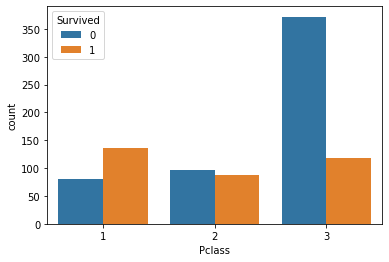

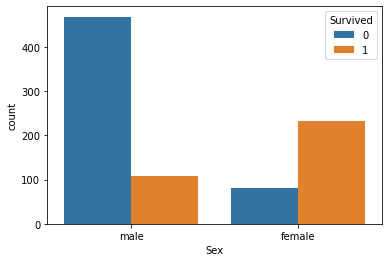

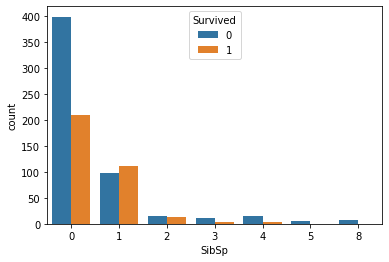

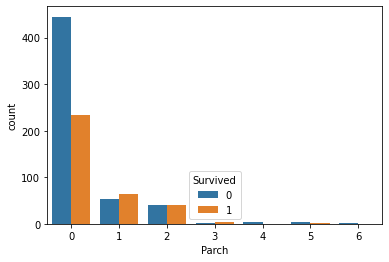

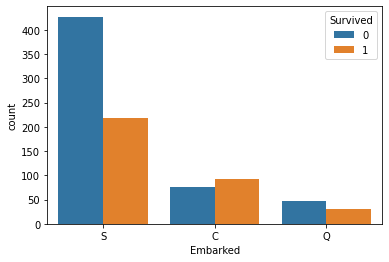

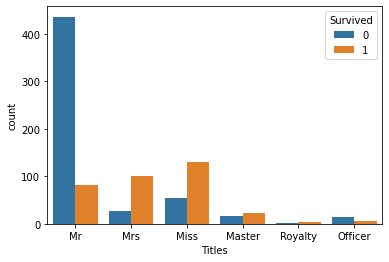

In [1101]:
for col in cat_cols:
    sns.countplot(data=train, x = col, hue = 'Survived')
    plt.show()

<h2> Feature Engineering </h2>
<p> There is one possibility of feature engineering that we are going to explore. We will be combining SibSp and Parch column to create family column. We will then test the statistical significance of the new column and compare it to the original columns.</p>
<p> One issue which we have not resolved is the high correlation of Sex and Titles column. Since Titles contains the information already in Sex column, we need to drop sec column.</p>

<h3> Creating Family column </h3>

In [1102]:
train['Family'] = (train['SibSp'].astype(int)+train['Parch'].astype(int)).astype(str)

In [1103]:
def chi2(col1, col2):
    stat, p, dof, expected = chi2_contingency(pd.crosstab(train[col1],train[col2]))
    alpha = 0.05
    if(p<alpha):
        print('p = ',p)
        print('Dependent (reject H0)')
    else:
        print('p = ',p)
        print('Independent (fail to reject H0)')

In [1104]:
print('Chi-Square test for SibSp')
chi2('SibSp','Survived')
print('*'*30)
print('Chi-Square test for Parch')
chi2('Parch','Survived')
print('*'*30)
print('Chi-Square test for family')
chi2('Family','Survived')
print('*'*30)

Chi-Square test for SibSp
p =  1.5585810465902147e-06
Dependent (reject H0)
******************************
Chi-Square test for Parch
p =  9.703526421039997e-05
Dependent (reject H0)
******************************
Chi-Square test for family
p =  3.5796689754435595e-14
Dependent (reject H0)
******************************


<h3> Green Signal on creating the family column </h3>
<p> We can see that family column has <i>greater statistical significance</i> than both of the columns combined. Hence we will be <b>droping SibSp and Parch</b> and <b>adding Family column</b></p>

In [1105]:
test['Family'] = (test['SibSp'].astype(int)+test['Parch'].astype(int)).astype(str)

In [1106]:
train.drop(columns=['SibSp','Parch'], inplace= True)
test.drop(columns=['SibSp','Parch'], inplace= True)

<h3> Checking correlation of Sex column and Titles column</h3>
<p> If they are highly correlated we will have to drop the sex column </p>

In [1107]:
chi2('Sex','Titles')

p =  1.657876515605297e-188
Dependent (reject H0)


<p> As we can see, both the columns ar highly correlated. Hence we will be dropping Sex column from the train and test dataset.</p>

In [1108]:
train.drop(columns='Sex', inplace= True)
test.drop(columns='Sex', inplace = True)

<h2> Data Preprocessing </h2>

<p> We have two numerical columns namely <b>Fare and Age</b> which need to be tranformed into a normal distribution</p>

<h3> Fare column </h3>

<h4> Before applying boxcox tranformation</h4>

<p> The probability plot tells us how the given distribution related to the normal distribution on the given quantiles</p>

(35.891199361614504, 32.204207968574636, 0.7204363989046636)

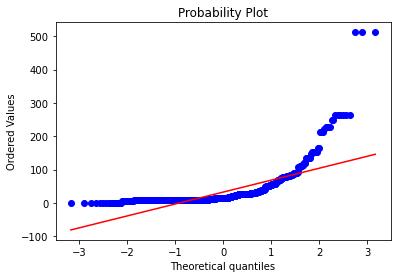

In [1109]:
stats.probplot(train['Fare'], dist='norm', plot=plt)[-1]

<h4>After applying boxcox transformation</h4>

In [1110]:
train['Fare'], fitted_lambda = boxcox(train['Fare']+1)

(0.6878022006280166, 2.5377994102267682, 0.9548723970863359)

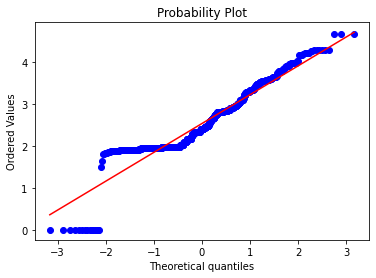

In [1111]:
stats.probplot(train['Fare'], dist='norm', plot=plt)[-1]

In [1112]:
test['Fare'], fitted_lambda = boxcox(test['Fare']+1)

<h3> Age column </h3>

<h4> Before applying the boxcox plot </h4>

(13.443995242981238, 29.427278127446026, 0.9897528052415783)

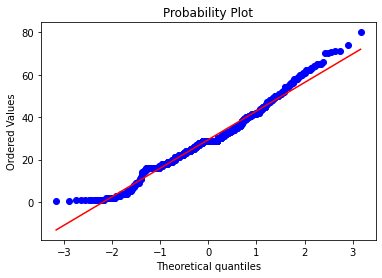

In [1113]:
stats.probplot(train['Age'], dist='norm', plot=plt)[-1]

<h4>After applying box plot</h4>

(6.739270230154552, 16.61749533865932, 0.9922028746145277)

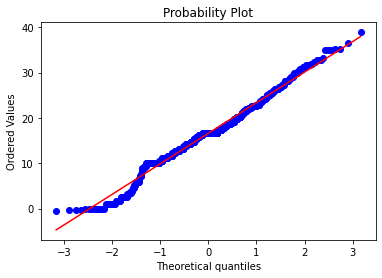

In [1114]:
stats.probplot(boxcox(train['Age'])[0], dist='norm', plot=plt)[-1]

<p>We can see that boxcox transformation on Age column does not bring about much change. There is a visible trade-off between the higher values and lower values before and after the transformation. Hence we will not apply boxcox tranformation on the Age column</p>

<h2> Preparing the data learning algorithm</h2>

In [1115]:
trainReg = train.copy()
testReg = test.copy()
df = trainReg.append(testReg)
df.head()

,PassengerId,Survived,Pclass,Name,Age,Fare,Embarked,Titles,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1.906724,S,Mr,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,3.497640,C,Mrs,1
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,1.970459,S,Miss,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,3.304258,S,Mrs,1
4,5,0.0,3,"Allen, Mr. William Henry",35.0,1.981680,S,Mr,0


<p> We will remove columns like <b>PassengerId and Name</b> Since they will not be used</p>

In [1116]:
df.drop(columns=['PassengerId','Name'], inplace=True)

<h2> Create dummy variables using One-Hot Encoding </h2>

In [1117]:
df = pd.get_dummies(df)

In [1118]:
df.shape

(1309, 24)

In [1119]:
trainReg_dummies = df.iloc[:len(trainReg)]
testReg_dummies = df.iloc[len(trainReg):]

In [1120]:
X_train = trainReg_dummies.drop(columns='Survived')
y_train = trainReg_dummies['Survived'].astype(int)
X_test = testReg_dummies.drop(columns='Survived')

<h3> Scaling the data using Standard Scaler

In [1121]:
scaler = StandardScaler()

In [1122]:
X_train_scaled = scaler.fit_transform(X_train)

In [1123]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [1124]:
X_test_scaled.shape

(418, 23)

In [1125]:
X_train_scaled.shape

(891, 23)

<h3> Fitting the Train Dataset to Logistic Regression model without hypertuning te parameters</h3>

In [1126]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled,y_train)
y_pred = logreg.predict(X_test_scaled)

In [1127]:
submission = pd.DataFrame()

In [1128]:
submission['PassengerId'] = np.arange(len(trainReg)+1, len(df)+1)

In [1129]:
submission['Survived'] = y_pred

In [1130]:
submission.shape

(418, 2)

In [1131]:
submission.to_csv('18J.csv')

In [1132]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [1133]:
def confusion_matrix_scorer(logreg, X,y):
    y_pred = logreg.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}

In [1134]:
logreg.coef_

array([[-0.39105627,  0.35105626,  0.47597156,  0.0141081 , -0.42158126,
         0.04618374,  0.04360396, -0.06789886,  0.35285444,  0.41947186,
        -0.87527865,  0.64517644, -0.2431546 , -0.01384882,  0.35286193,
         0.04734655, -0.49157111,  0.06327162,  0.04530697, -0.3232523 ,
        -0.48519897, -0.15947999, -0.49407526]])

In [1135]:
score = cross_validate(logreg, X_train_scaled, y_train,scoring=['accuracy','precision','recall'],cv=5)

In [1136]:
score

{'fit_time': array([0.02615881, 0.02780604, 0.02226686, 0.02540135, 0.02509856]),
 'score_time': array([0.00378919, 0.00407648, 0.00339603, 0.00365376, 0.00328636]),
 'test_accuracy': array([0.82122905, 0.8258427 , 0.80337079, 0.80337079, 0.85955056]),
 'test_precision': array([0.75342466, 0.78461538, 0.74626866, 0.82352941, 0.84375   ]),
 'test_recall': array([0.79710145, 0.75      , 0.73529412, 0.61764706, 0.7826087 ])}

In [1137]:
score = cross_validate(logreg, X_train_scaled, y_train,scoring=confusion_matrix_scorer,cv=5)

In [1138]:
score

{'fit_time': array([0.04387856, 0.05011415, 0.0364418 , 0.05452919, 0.03772926]),
 'score_time': array([0.0013535 , 0.00127363, 0.00124478, 0.00140238, 0.00149274]),
 'test_tn': array([ 92,  96,  93, 101,  99]),
 'test_fp': array([18, 14, 17,  9, 10]),
 'test_fn': array([14, 17, 18, 26, 15]),
 'test_tp': array([55, 51, 50, 42, 54])}

<h2> Using Label Encoder </h2>

In [1139]:
df = trainReg.append(testReg)

In [1140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   object 
 3   Name         1309 non-null   object 
 4   Age          1309 non-null   float64
 5   Fare         1309 non-null   float64
 6   Embarked     1309 non-null   object 
 7   Titles       1309 non-null   object 
 8   Family       1309 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 102.3+ KB


<p> We will use Label Encoder here and check our results</p>

In [1141]:
def enc(df):
    lb = LabelEncoder()
    return (lb.fit_transform(df))

In [1142]:
df.drop(columns=['PassengerId','Name'], inplace = True)

In [1143]:
lb = LabelEncoder()

In [1144]:
df['Pclass'] = lb.fit_transform(df['Pclass'])

In [1145]:
df['Pclass'].value_counts()

2    709
0    323
1    277
Name: Pclass, dtype: int64

In [1146]:
df['Embarked'] = lb.fit_transform(df['Embarked'])

In [1147]:
df['Embarked'].value_counts()

2    916
0    270
1    123
Name: Embarked, dtype: int64

In [1148]:
df['Titles'] = lb.fit_transform(df['Titles'])

In [1149]:
df['Titles'].value_counts()

2    757
1    264
3    198
0     61
4     24
5      5
Name: Titles, dtype: int64

In [1150]:
df['Family'] = lb.fit_transform(df['Family'])

In [1151]:
df['Family'].value_counts()

0    790
1    235
3    159
4     43
6     25
5     22
7     16
2     11
8      8
Name: Family, dtype: int64

In [1152]:
trainReg_dummies = df.iloc[:len(trainReg)]
testReg_dummies = df.iloc[len(trainReg):]
X_train = trainReg_dummies.drop(columns='Survived')
y_train = trainReg_dummies['Survived'].astype(int)
X_test = testReg_dummies.drop(columns='Survived')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [1153]:
X_train_scaled.shape

(891, 6)

In [1154]:
X_test_scaled.shape

(418, 6)

In [1155]:
logreg = LogisticRegression()
score = cross_validate(logreg, X_train_scaled, y_train,scoring=['accuracy','precision','recall'],cv=5)
score

{'fit_time': array([0.00516844, 0.0060463 , 0.00673842, 0.00484967, 0.00437784]),
 'score_time': array([0.00369906, 0.00421381, 0.0040822 , 0.00251484, 0.00365996]),
 'test_accuracy': array([0.60893855, 0.67977528, 0.74719101, 0.79213483, 0.7247191 ]),
 'test_precision': array([0.48888889, 0.60784314, 0.76744186, 0.80392157, 0.7173913 ]),
 'test_recall': array([0.31884058, 0.45588235, 0.48529412, 0.60294118, 0.47826087])}

<h2> Result of Encoders </h2>

<p> It is clear that One-Hot Encoding gives better results than Label Encoding. This is because the categorical variable cannot be considered to be ordinal variables. The realtionship between the elements is not linear. </p>

<h1> Using GridSearchCV to optimize the Hyperparameters </h1>

In [1156]:
df = trainReg.append(testReg)
df.drop(columns=['PassengerId','Name'], inplace=True)
df = pd.get_dummies(df)
trainReg_dummies = df.iloc[:len(trainReg)]
testReg_dummies = df.iloc[len(trainReg):]
X_train = trainReg_dummies.drop(columns='Survived')
y_train = trainReg_dummies['Survived'].astype(int)
X_test = testReg_dummies.drop(columns='Survived')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

In [1157]:
param_grid = [
    {
    'penalty' : ['l1'],
    'C' : np.logspace(-4,4,20),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [100,500,1000,5000,10000],
}
]

In [1158]:
logreg = LogisticRegression()
clf = GridSearchCV(logreg, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [1159]:
best_clf = clf.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/home/kabir/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.61616345        nan 0.61616345        nan
        nan 0.61616345        nan 0.61616345        nan        nan
 0.61616345        nan 0.61616345        nan        nan 0.61616345
        nan 0.61616345        nan        nan 0.61616345        nan
 0.61616345        nan        nan 0.61616345        nan 0.61616345
        nan        nan 0.61616345        nan 0.61616345        nan
        nan 0.61616345        nan 0.61616345        nan        nan
 0.61616345        nan 0.61616345        nan        nan 0.61616345
        nan 0.61616345        nan        nan 0.61616345        nan
 0.61616345        nan        nan 0.61616345        nan 0.61616345
        nan        nan 0.61616345        nan 0.61616345        nan
        nan 0.61616345        nan 0.61616345        nan        nan
 0.61616345        nan 0.61616345        nan  

In [1160]:
best_clf.best_estimator_

LogisticRegression(C=4.281332398719396, penalty='l1', solver='liblinear')

In [1161]:
best_clf.score(X_train_scaled, y_train)

0.8271604938271605

In [1162]:
y_pred = best_clf.predict(X_test_scaled)

In [1163]:
submission = pd.DataFrame()

In [1164]:
submission['PassengerId'] = np.arange(len(trainReg)+1, len(df)+1)
submission['Survived'] = y_pred
submission.shape

(418, 2)

In [1165]:
submission.to_csv('18J2.csv',index = False)